# Spatial Interpolation - Part 1

<br>



<br>

## Analysis Preparation

### Imports

All of these libraries should have been previously installed during the environment set-up, if they have not been installed already you can use ```install.packages(c("raster", "rgdal", "ape", "scales", "deldir", "gstat"))```

In [121]:
library(raster) # rasters
library(rgdal)  # spatial data
library(sf)     # for handling spatial features
library(ape)    # clustering (Morans I)
library(scales) # transparencies
library(deldir) # triangulation
library(gstat)  # geostatistics

source('../scripts/helpers.R') # helper script, note that '../' is used to change into the directory above the directory this notebook is in

<br>

### Loading Data

We'll start by again checking to see if we need to download any data.

In [2]:
download_data()

<br>

We'll then load in the datasets.

In [3]:
df_zambia <- read_sf('../data/zambia/zambia.shp')
df_africa_cities <- read_sf('../data/africa/cities.shp')
solar <- raster('../data/zambia/solar.tif')
altitude <- raster('../data/zambia/altitude.tif')

<br>

Do some pre-processing on the zambian cities dataset (which we'll use as points in our Voronoi diagram later).

In [4]:
df_zambian_cities <- df_africa_cities[which(df_africa_cities$COUNTRY=='Zambia'), ]
df_zambian_cities_UTM35S <- st_transform(df_zambian_cities, crs=st_crs(20935))

head(df_zambian_cities_UTM35S, 3)

LATLONGID LATITUDE  LONGITUDE URBORRUR YEAR ES90POP ES95POP ES00POP INSGRUSED
1 4         -12.65000 28.08333  U        1990   9945   10684   11218  N        
2 7         -12.36667 27.83333  U        1990  48055   51629   54206  N        
3 9         -12.53333 27.85000  U        1990 142383  152972  160610  N        
  CONTINENT ⋯ SCHADMNM   ADMNM1     ADMNM2        TYPE SRCTYP    COORDSRCE
1 Africa    ⋯ COPPERBELT Copperbelt Kalulushi     UA   Published NIMA     
2 Africa    ⋯ COPPERBELT Copperbelt Chililabombwe UA   Published NIMA     
3 Africa    ⋯ COPPERBELT Copperbelt Chingola      UA   Published NIMA     
  DATSRC                                                              
1 Census of Population, Housing & Argriculture 1990 Descriptive Tables
2 Census of Population, Housing & Argriculture 1990 Descriptive Tables
3 Census of Population, Housing & Argriculture 1990 Descriptive Tables
  LOCNDATSRC             NOTES geometry                
1 UN Statistical Library NA    POINT (617646.2 8601614)
2 UN Statistical Library NA    POINT (590593.6 8633048)
3 UN Statistical Library NA    POINT (592346.6 8614610)

<br>

We'll visualise these as well

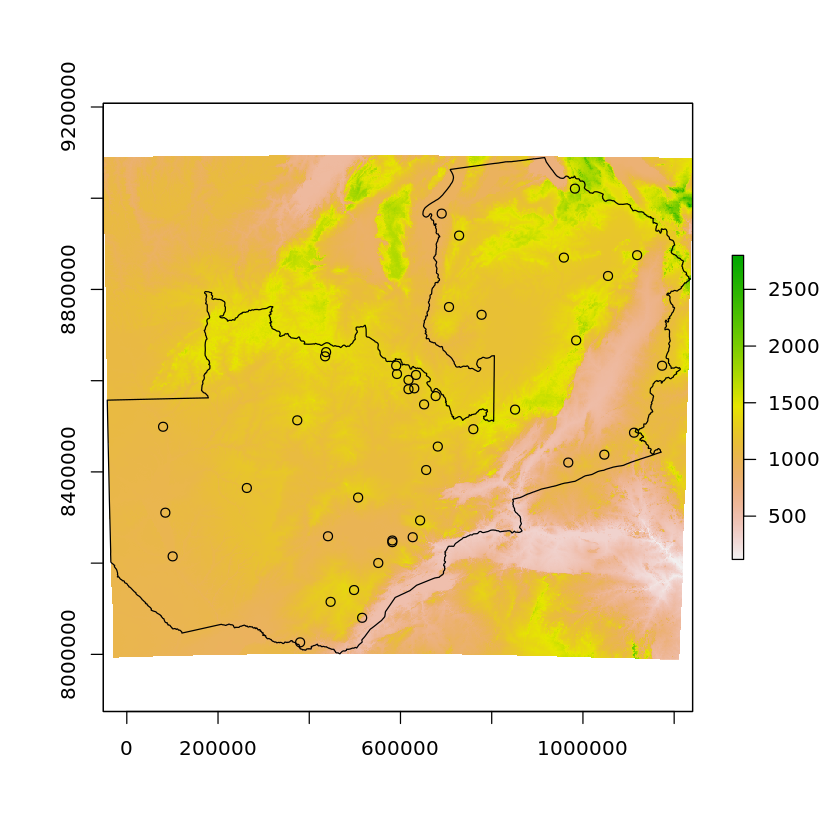

In [5]:
plot(altitude)
plot(df_zambia['geometry'], add=TRUE)
plot(df_zambian_cities_UTM35S['geometry'], add=TRUE)

<br>

### Voronoi Tesselation/Thiessen Polygons

Before we move on to interpolation we'll look at how we can create a Voronoi diagram:

> ... a partitioning of a plane into regions based on distance to points in a specific subset of the plane. That set of points (called seeds, sites, or generators) is specified beforehand, and for each seed there is a corresponding region consisting of all points closer to that seed than to any other. - [Wikipedia](https://en.wikipedia.org/wiki/Voronoi_diagram)

We'll now use the `deldir` function to carry out Delaunay triangulation and Dirichlet tessellation, this function returns a complex object.

In [6]:
cities_deldir <- deldir(df_zambian_cities_UTM35S$LONGITUDE, df_zambian_cities_UTM35S$LATITUDE)

cities_deldir


Delaunay triangulation and Dirchlet tessellation
of 43 data points.

Enclosing rectangular window:
[22.11,34.190001] x [-18.751667,-7.931666] 

Area of rectangular window (total area of
Dirichlet tiles):
130.7056 

Area of convex hull of points (total area of
Delaunay triangles):
54.96517 


<br>

We can use `tile.list` to convert the complex object returned in the last step into a list where each entry is a separate Dirichlet/Voronoi tile

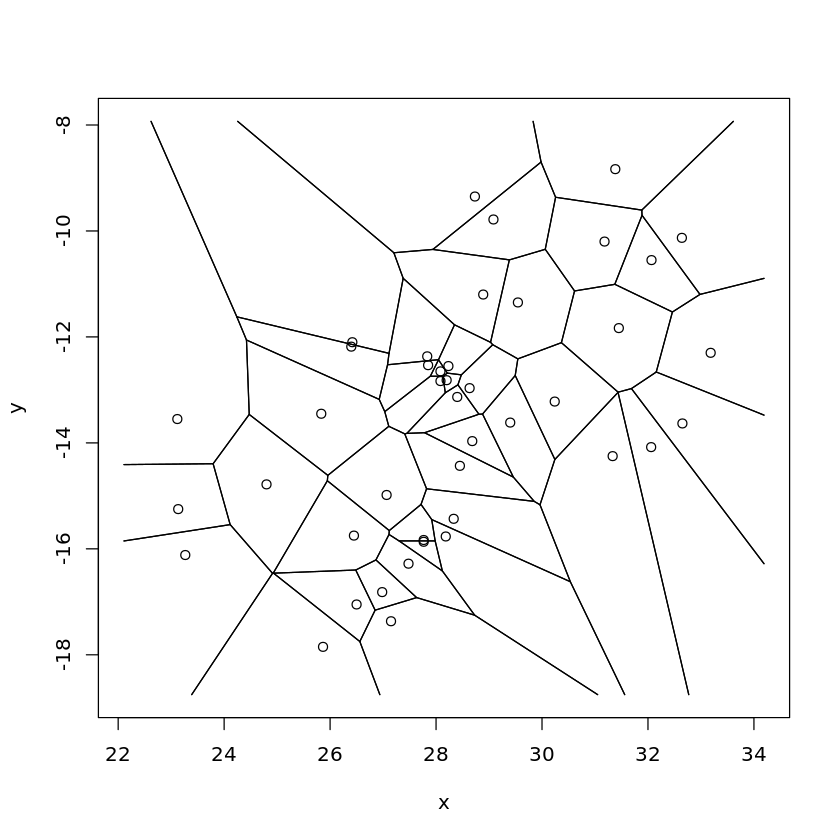

In [7]:
cities_polygons <- tile.list(cities_deldir) # Produces Thiessen polygons

plot(cities_polygons)

<br>

We can then susbset the returned object, with each element relating to a single city in the original dataset, the `area` attribute is the size of the Polygon for that city.

In [8]:
cities_polygons[[1]]

$ptNum
[1] 1

$pt
        x         y 
 28.08333 -12.65000 

$x
[1] 28.04643 27.89167 28.12976 28.21364

$y
[1] -12.43214 -12.74167 -12.74167 -12.68295

$bp
[1] FALSE FALSE FALSE FALSE

$area
[1] 0.052275

<br>

### Interpolation

Before we start interpolating we'll quickly inspect the dataset for any clear trends, starting with the lon/lat & altitude relationship with solar potential.

First we'll extract the solar and altitude values for the points we've selected (just so happens to be cities in this case).

In [53]:
city_coords = st_coordinates(df_zambian_cities_UTM35S)

df_zambian_cities_UTM35S$solar <- extract(solar, city_coords)
df_zambian_cities_UTM35S$altitude <- extract(altitude, city_coords)

df_zambian_cities_UTM35S$x <- city_coords[, 1]
df_zambian_cities_UTM35S$y <- city_coords[, 2]

<br>

Longitude appears to have a weak relationship with solar output

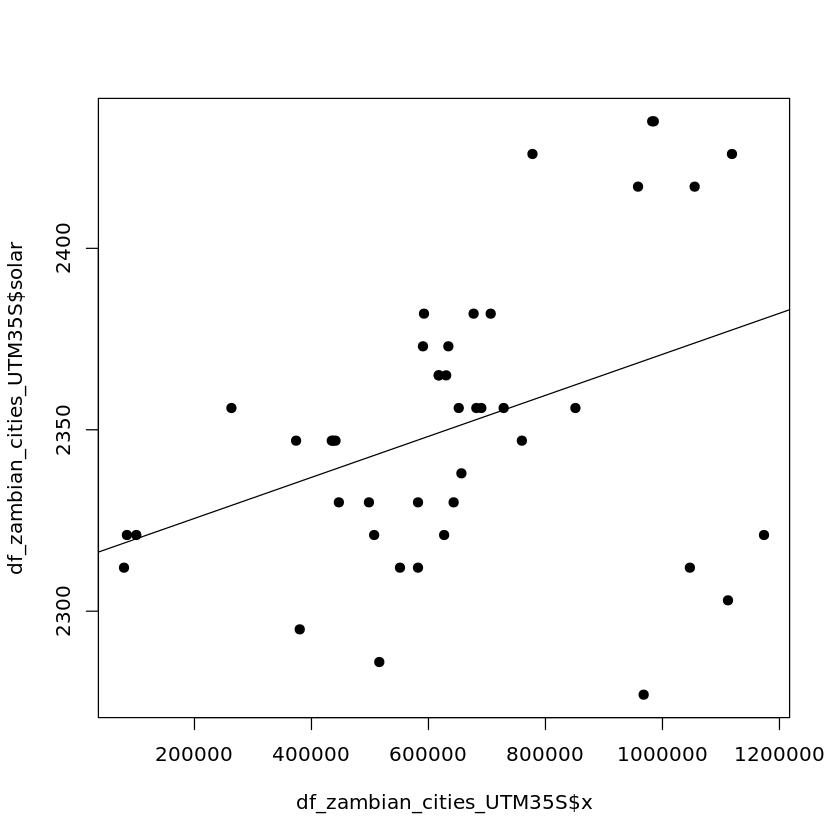

In [54]:
plot(df_zambian_cities_UTM35S$x, df_zambian_cities_UTM35S$solar, pch=19)
abline(lm(df_zambian_cities_UTM35S$solar ~ df_zambian_cities_UTM35S$x))

<br>

Latitude appears to have a stronger relationship with solar output which would be expected (why do you think this is?).

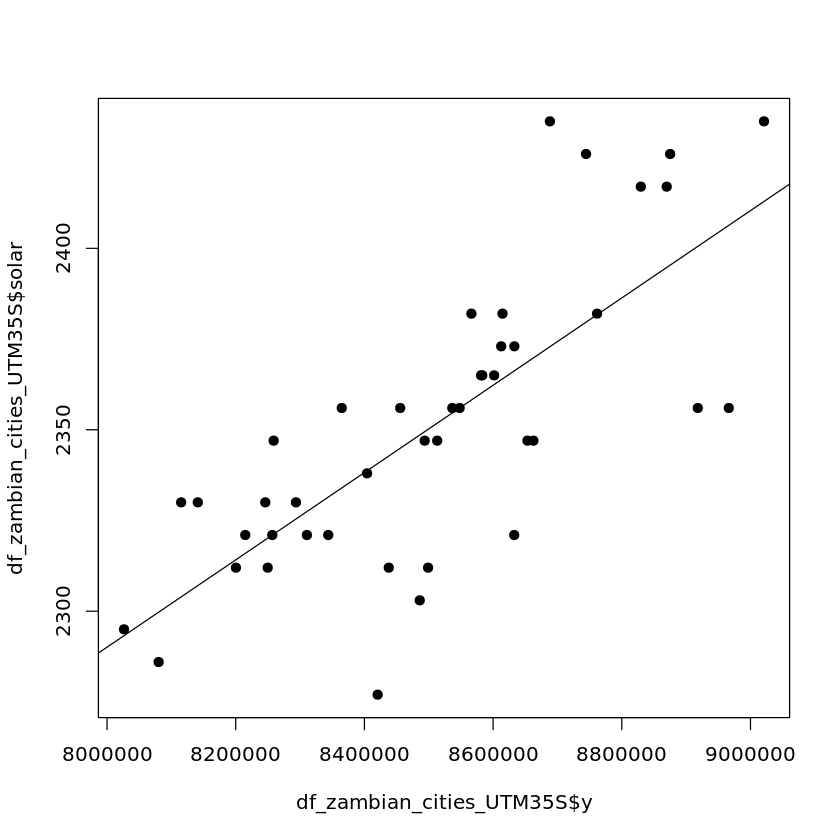

In [55]:
plot(df_zambian_cities_UTM35S$y, df_zambian_cities_UTM35S$solar, pch=19)
abline(lm(df_zambian_cities_UTM35S$solar ~ df_zambian_cities_UTM35S$y))

<br>

We'll now create a model that predicts solar based on a 1st order linear regression against longitude/latitude.

In [115]:
trend_1st <- lm(solar~x+y, data=df_zambian_cities_UTM35S)
summary(trend_1st)


Call:
lm(formula = solar ~ x + y, data = df_zambian_cities_UTM35S)

Residuals:
    Min      1Q  Median      3Q     Max 
-63.083  -9.265   1.744  19.652  62.488 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.321e+03  1.605e+02   8.230 3.87e-10 ***
x           -1.636e-06  1.804e-05  -0.091    0.928    
y            1.212e-04  1.954e-05   6.203 2.45e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 26.87 on 40 degrees of freedom
Multiple R-squared:  0.5649,	Adjusted R-squared:  0.5432 
F-statistic: 25.97 on 2 and 40 DF,  p-value: 5.903e-08


<br>

We'll now create a grid that we will carry out the predictions over

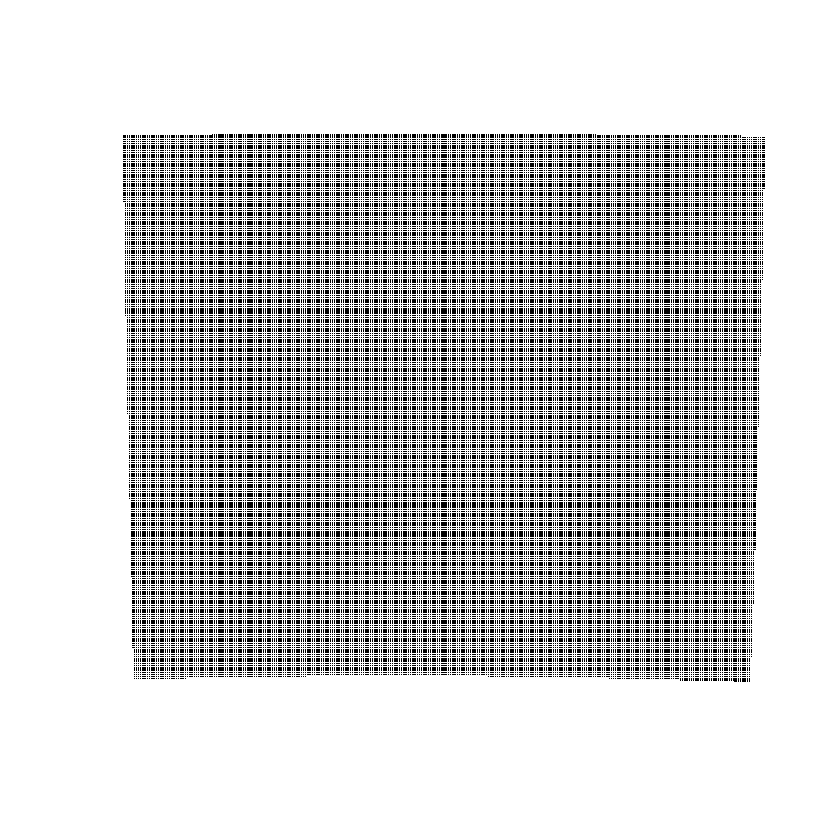

In [116]:
grid <- st_as_sf(rasterToPoints(solar, spatial=TRUE)) # uses existing raster cell centres as point locations
grid$solar <- NULL # clear existing data

plot(grid, pch=".")

<br>

We'll now populate this empty grid with the x/y values and solar/altitude values

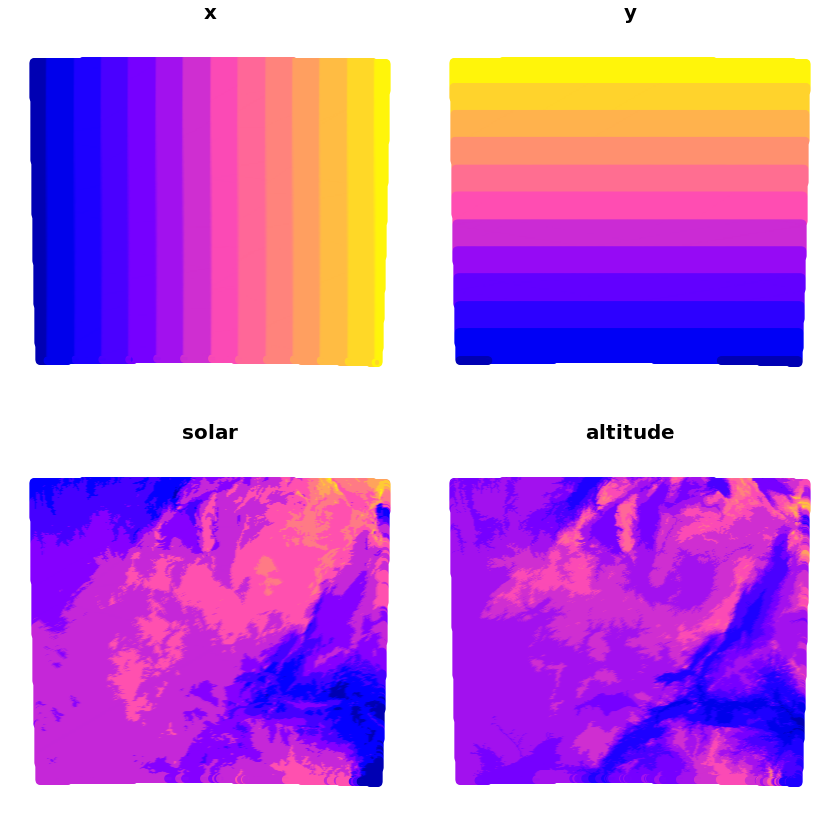

In [117]:
grid_coords <- as.data.frame(st_coordinates(grid))

grid$x <- grid_coords[, 1]
grid$y <- grid_coords[, 2]

grid$solar <- extract(solar, grid_coords[, 1:2])
grid$altitude <- extract(altitude, grid_coords[, 1:2])

plot(grid)

<br>

We can now make the prediction which we'll compare with the true solar values, we can see that whilst it captures some of the wider characteristics there are a lot of discrepancies still.

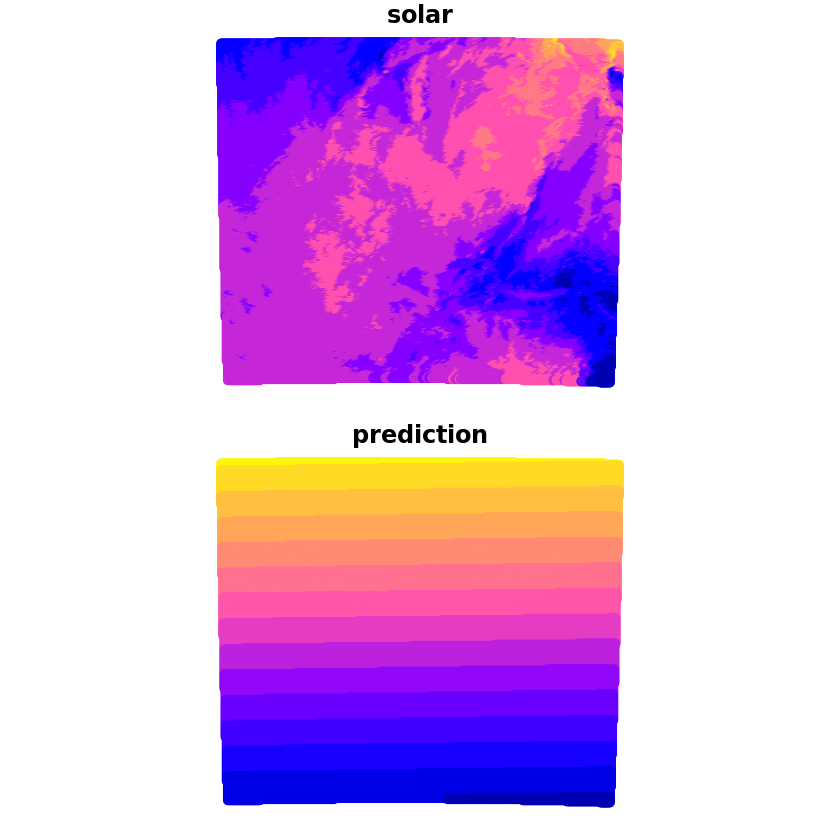

In [118]:
grid_pred <- predict(trend_1st, newdata=grid, se.fit=TRUE)
grid$prediction <- grid_pred$fit

plot(grid[c('solar', 'prediction')])

<br>

We don't just have to regress against longitude/latitude though, here we'll repeat the previous steps but only use latitude as a regressor.

First we'll visualise the relationship between the two.

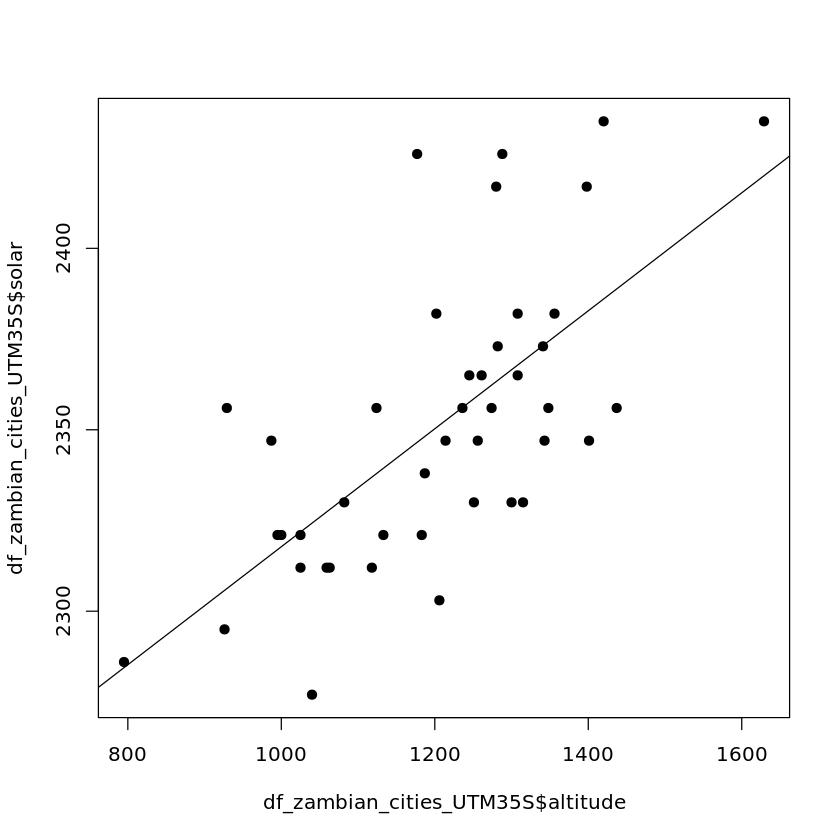

In [119]:
plot(df_zambian_cities_UTM35S$altitude, df_zambian_cities_UTM35S$solar, pch=19)
abline(lm(df_zambian_cities_UTM35S$solar ~ df_zambian_cities_UTM35S$altitude))

<br>

Then we'll fit a model and use it in our prediction.

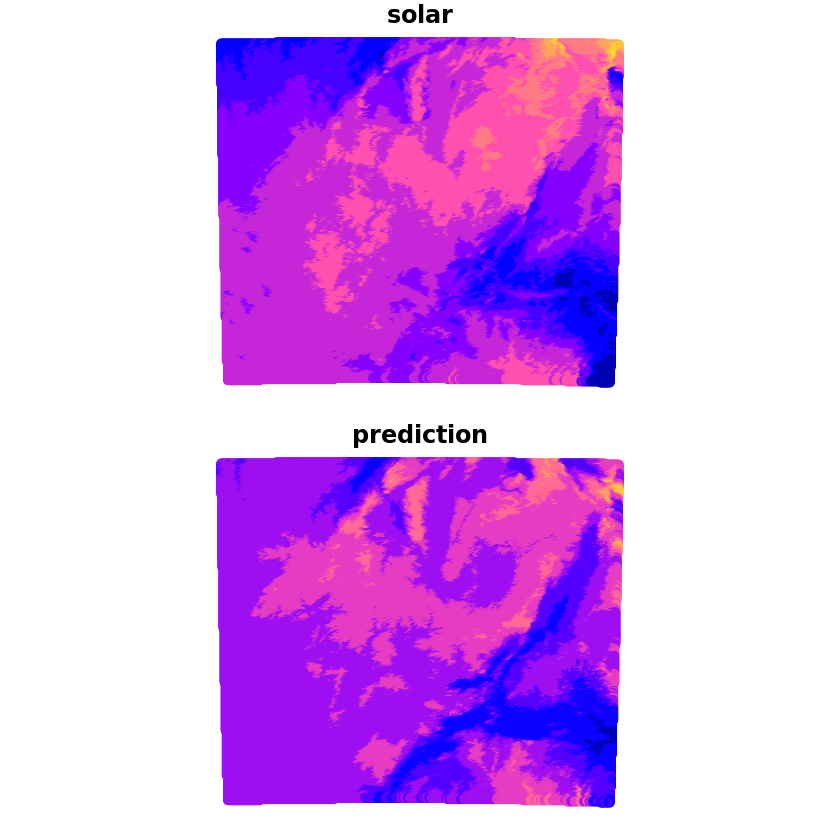

In [120]:
trend_1st <- lm(solar~altitude, data=df_zambian_cities_UTM35S)

grid_pred <- predict(trend_1st, newdata=grid, se.fit=TRUE)
grid$prediction <- grid_pred$fit

plot(grid[c('solar', 'prediction')])

<br>

### Questions

#### Best Fit Model

* What combination of the inputs produces the most accurate results? 
* Should we use the standard r2 score or the adjusted r2 score?
* How do the results change when you use a test/train split? 
* How could we improve over a random sample on the test/train split? (Think about what you would do with time-series cross-validation)

In [ ]:
# 